<a href="https://colab.research.google.com/github/Uttam1998/Outlier_Prediction/blob/master/Outlier_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uplaoded = files.upload()

Saving Melbourne_housing_FULL.csv to Melbourne_housing_FULL.csv


In [3]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Parametric** **methods**: **Univariate** 

Create a dummy dataframe where features have normal distributions to practice parametric methods.

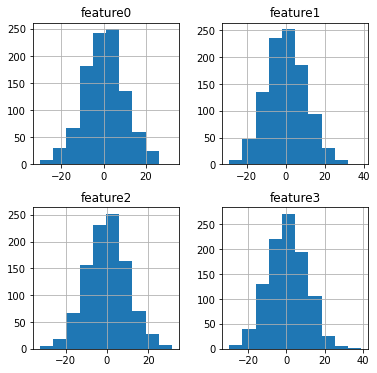

In [4]:
# seed for reproducibility
np.random.seed(42)
n_feats=4
dummydf = pd.DataFrame(np.random.normal(scale=10.0, size=(1000, n_feats)),
                           columns=['feature{}'.format(i) for i in range(n_feats)])
# all normally distributed
dummydf.hist(figsize=(6,6));

In [5]:
# enough variation between features to show outliers
dummydf.describe()

,feature0,feature1,feature2,feature3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.306239,0.248285,-0.082552,0.300861
std,9.639191,10.118843,10.060754,10.069640
min,-30.195122,-28.962554,-32.412673,-29.911360
25%,-6.129422,-6.770368,-6.752986,-6.708710
50%,0.561874,0.202097,-0.075088,0.211577
75%,6.648813,6.938808,6.422820,6.958780
max,32.430930,38.527315,31.520567,39.262377


In [7]:
def out_std(s, nstd=3.0, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series
    using standard deviation, works column-wise.
    param nstd:
        Set number of standard deviations from the mean
        to consider an outlier
    :type nstd: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]

def out_iqr(s, k=1.5, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series
    using interquartile range, works column-wise.
    param k:
        some cutoff to multiply by the iqr
    :type k: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    # calculate interquartile range
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return [True if x < lower or x > upper else False for x in s]


Standard Deviation

In [8]:
# outlier_mask is a boolean list identifies the indices of the outliers
outlier_mask = out_std(dummydf['feature0'], nstd=3.0)
# first 10 elements
outlier_mask[:10]

[False, False, False, False, False, False, False, False, False, False]

Identify the outliers, notice these values are on both low and high.

In [9]:
dummydf['feature0'][outlier_mask]

506   -30.195122
788   -29.069882
929    32.430930
Name: feature0, dtype: float64

Visualize the outliers in the context of the feature's distribution.

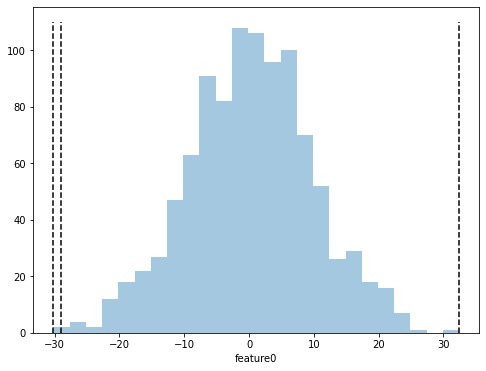

In [10]:
plt.figure(figsize=(8,6))
sns.distplot(dummydf['feature0'], kde=False);
plt.vlines(dummydf['feature0'][outlier_mask], ymin=0, ymax=110, linestyles='dashed');

Compare Standard Deviation and IQR

In [11]:
# For comparison, make one array each using standard deviations of 2.0, 3.0 and 4.0.
std2 = dummydf.apply(out_std, nstd=2.0)
std3 = dummydf.apply(out_std, nstd=3.0)
std4 = dummydf.apply(out_std, nstd=4.0)

# For comparison, make one array each at varying values of k.
iqr1 = dummydf.apply(out_iqr, k=1.5)
iqr2 = dummydf.apply(out_iqr, k=2.0)
iqr3 = dummydf.apply(out_iqr, k=3.0)

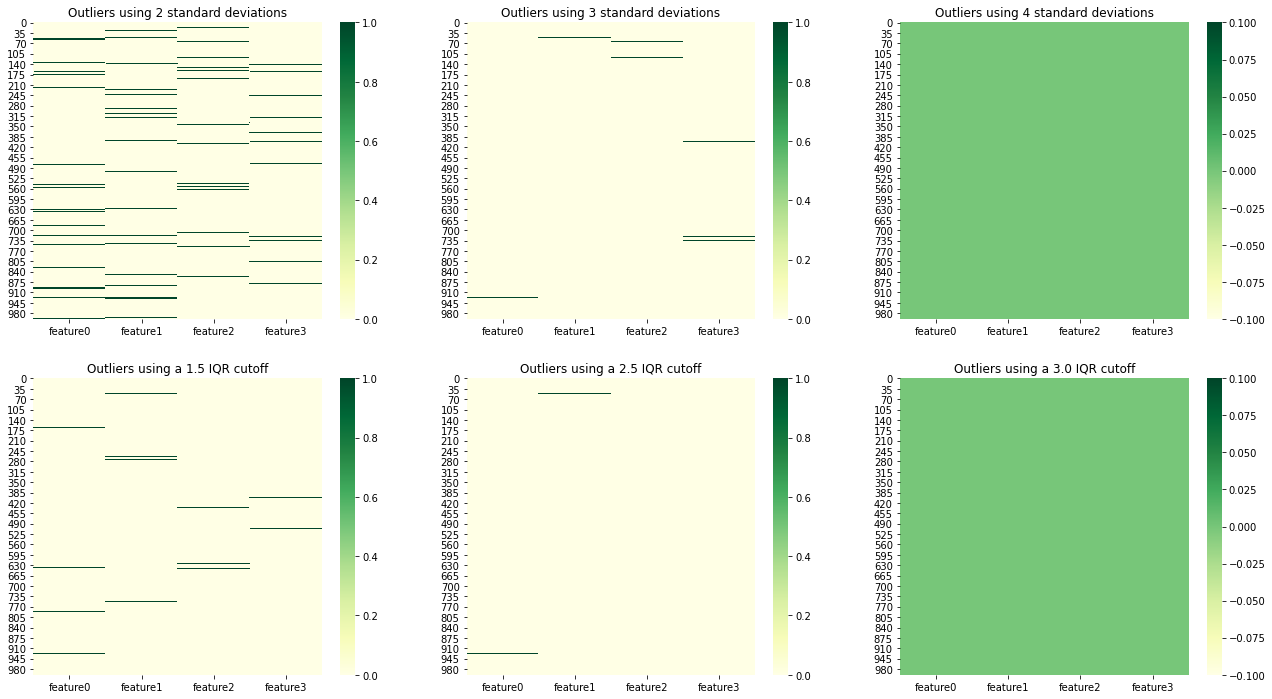

In [13]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows=2, figsize=(22, 12));
ax1.set_title('Outliers using 2 standard deviations');
ax2.set_title('Outliers using 3 standard deviations');
ax3.set_title('Outliers using 4 standard deviations');
ax4.set_title('Outliers using a 1.5 IQR cutoff');
ax5.set_title('Outliers using a 2.5 IQR cutoff');
ax6.set_title('Outliers using a 3.0 IQR cutoff');

sns.heatmap(std2, cmap='YlGn', ax=ax1);
sns.heatmap(std3, cmap='YlGn', ax=ax2);
sns.heatmap(std4, cmap='YlGn', ax=ax3);
sns.heatmap(iqr1, cmap='YlGn', ax=ax4);
sns.heatmap(iqr2, cmap='YlGn', ax=ax5);
sns.heatmap(iqr3, cmap='YlGn', ax=ax6);

plt.savefig('outliers.png') 
plt.show()


A detailed visualization of the different standard deviation cutoffs for feature0, note return_thresholds=True in the outlier function:

In [14]:
def plot_cutoff(dataframe, col, nstd=2.0, color='red'):
    """
    Version 8 update: more generic function.
    Function added in Version 6, more readable code than previous versions.
    From version 4 update: 
    This code block will plot lower and upper thresholds.
    I'm still thinking about how to best visualize this, suggestions welcome!
    """
    lower, upper = out_std(dataframe[col], nstd=nstd, return_thresholds=True)
    plt.axvspan(min(dataframe[col][dataframe[col] < lower], default=dataframe[col].min()), lower, alpha=0.2, color=color);
    plt.axvspan(upper, max(dataframe[col][dataframe[col] > upper], default=dataframe[col].max()), alpha=0.2, color=color);

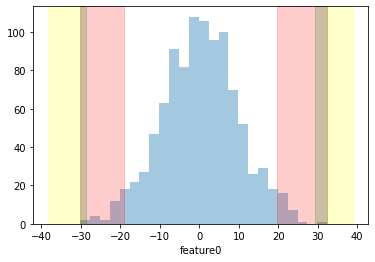

In [15]:
column = 'feature0'
sns.distplot(dummydf[column], kde=False)
plot_cutoff(dummydf, column, nstd=2.0, color='red');
plot_cutoff(dummydf, column, nstd=3.0, color='green');
plot_cutoff(dummydf, column, nstd=4.0, color='yellow');

**Nonparametric** **methods**: **Univariate**

The features in the Melbourne Housing dataset are skewed, they should serve as good distributions to test nonparametric outlier detection method.

In [16]:
df = pd.read_csv('/content/Melbourne_housing_FULL.csv')

In [17]:
# for this exercise, just fill missing values with the median value for a column.
# Using median ensures filled values will be whole numbers.
df.fillna(df.median(), inplace=True)

Limit the detection of outliers to a subset of the columns in this particular dataset.

In [18]:
cols = ['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'Propertycount']

Visualize the distribution of the features.

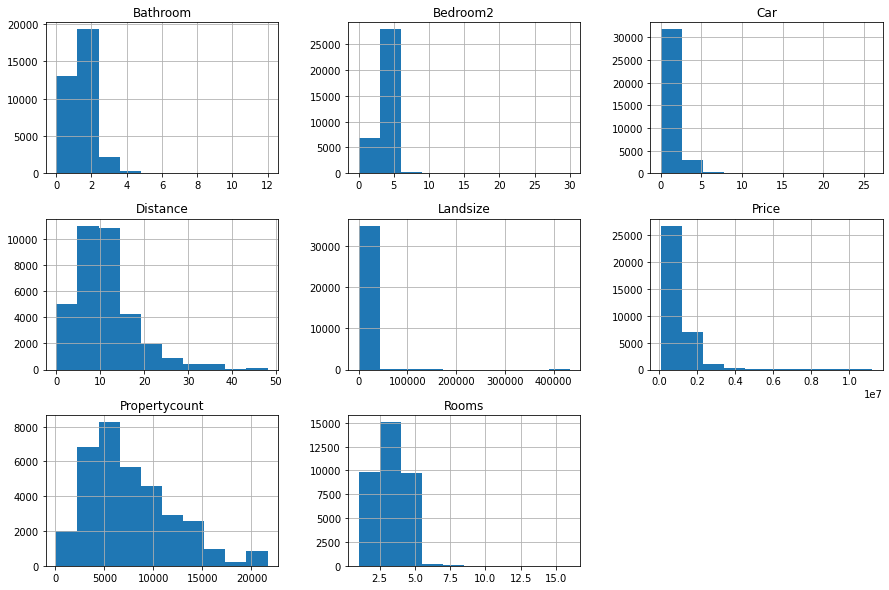

In [19]:
df[cols].hist(figsize=(15,10));

**Isolation** **Forest**

IsolationForest is implemented in scikit-learn. It returns an anomaly_score for each data point. Code below is modified from a short tutorial.

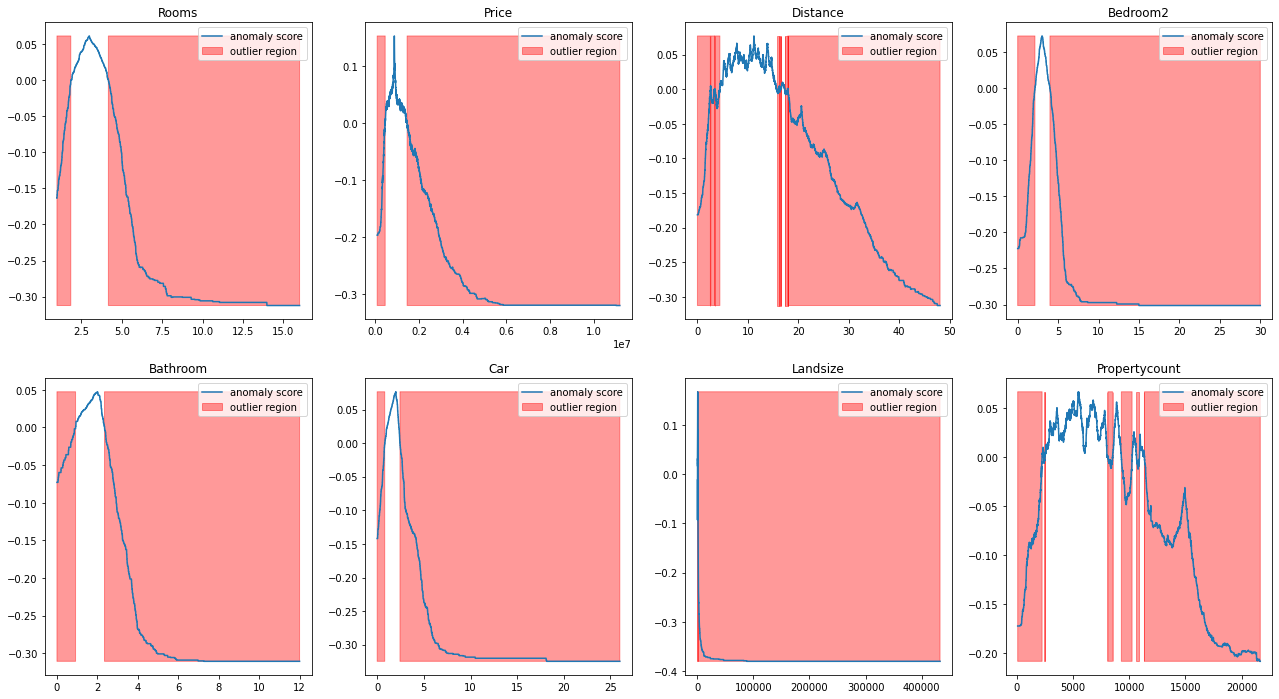

In [20]:
fig, axs = plt.subplots(2, 4, figsize=(22, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df[column].values.reshape(-1,1))

    xx = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

**Parametric** **methods**: **Multivariate**

I will show multivariate outlier detection using two scikit-learn methods: For normally distributed data (ex. dummydf), use EllipticEnvelope.

**EllipticEnvelope**

For visualization purposes, use the first two features

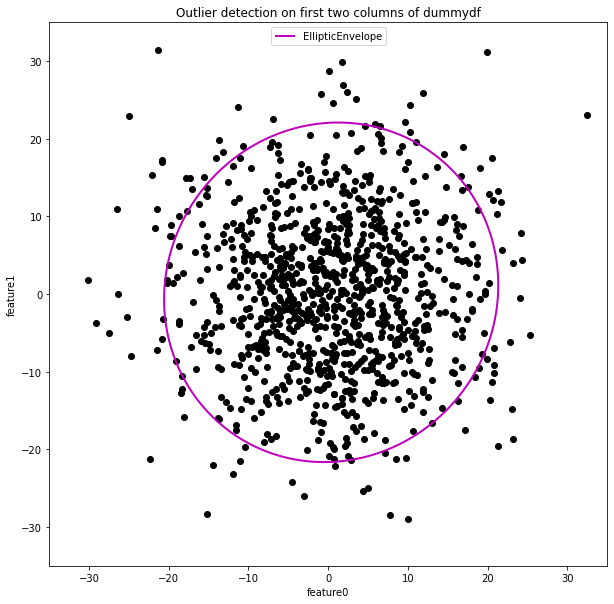

In [21]:
clf = EllipticEnvelope()

legend = {}
xx, yy = np.meshgrid(np.linspace(-35, 35, 500), np.linspace(-35, 35, 500))
plt.figure(1, figsize=(10,10))
clf.fit(dummydf.values[:,:2])
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
legend['EllipticEnvelope'] = plt.contour(
    xx, yy, Z, levels=[0], linewidths=2, colors=['m'])

legend_values_list = list(legend.values())
legend_keys_list = list(legend.keys())

plt.figure(1, figsize=(10,10))# two clusters
plt.title("Outlier detection on first two columns of dummydf")
plt.scatter(dummydf.values[:, 0], dummydf.values[:, 1], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")

plt.xlim((xx.min(), xx.max()))
plt.ylim((yy.min(), yy.max()))
plt.legend(legend_values_list[0].collections, legend_keys_list,
           loc="upper center");
plt.ylabel("feature1");
plt.xlabel("feature0");

**Nonparametric** **methods**: **Multivariate**


**DBSCAN**

DBSCAN on Melbourne Housing Data

In [25]:
# scale data first
X = StandardScaler().fit_transform(df[cols].values)

db = DBSCAN(eps=3.0, min_samples=10).fit(X)
labels = db.labels_

In [24]:
pd.Series(labels).value_counts()

 0    34797
-1       60
dtype: int64

Visualize the outlier samples in the context of the first two features, Rooms and Price

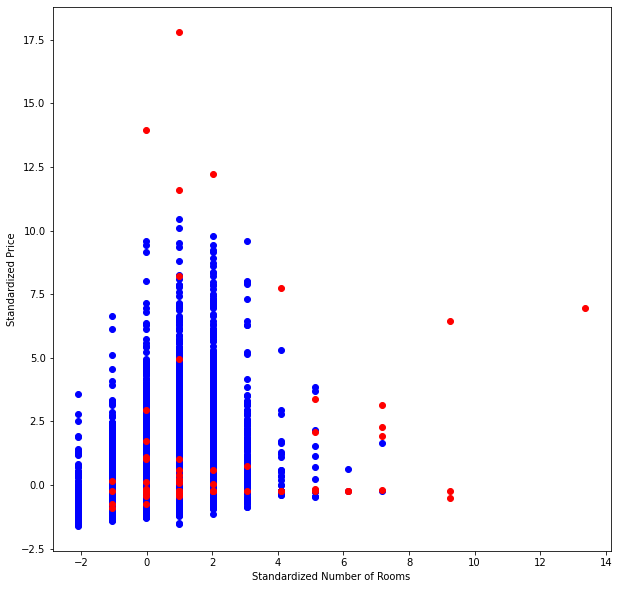

In [26]:
plt.figure(figsize=(10,10))

unique_labels = set(labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,0][sample_mask], X[:, 1][sample_mask], 'o', color=color);
plt.xlabel('Standardized Number of Rooms');
plt.ylabel('Standardized Price');


**LocalOutlierFactor**

I tried detecting outliers in the first two features again, but LocalOutlierFactor may require fine-tuning.

In [27]:
clf = LocalOutlierFactor(n_neighbors=50, contamination='auto')
y_pred = clf.fit_predict(X[:,:2])

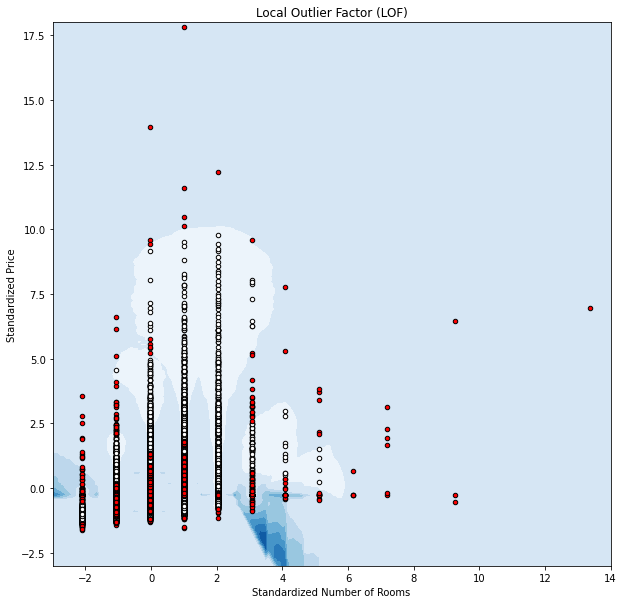

In [28]:
plt.figure(figsize=(10,10))
# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-3, 14, num=200), np.linspace(-3, 18, num=200))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c='white',
                edgecolor='k', s=20)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c='red',
                edgecolor='k', s=20)
plt.axis('tight')
plt.xlabel('Standardized Number of Rooms');
plt.ylabel('Standardized Price');
plt.show()